# Task1 Data Acquisition

In [553]:
import os
import csv
import urllib
import json
import math

import pandas as pd
import numpy as np
import datetime
from alpha_vantage.timeseries import TimeSeries
from covid19dh import covid19
import requests
import matplotlib.pyplot as plt
import dataframe_image as dfi
import pickle
import seaborn as sns
from scipy import stats
from matplotlib.ticker import MultipleLocator

import time
from meteostat import Point
from meteostat import Daily

from numpy import sqrt, abs, round
from scipy.stats import norm

In [58]:
start_date = datetime.datetime(2017, 4, 1)
end_date = datetime.datetime(2022, 5, 31)

In [317]:
def save_plot(name, plot):
    fig_dir='./Figures'
    plt.tight_layout()# Display appropiately.
    if not os.path.exists(fig_dir):
        os.makedirs(fig_dir) 
    file = os.path.join(fig_dir, (str(name) +' '+ str(plot) + ".jpg"))
    plt.savefig(file)
    plt.clf()  # Clear figure
    plt.cla()  # Clear axes
    plt.close()
    return

In [60]:
def save_file(dir,df,filename):
    if not os.path.exists(dir):
        os.makedirs(dir)
    df.to_pickle(os.path.join(dir, f'{filename}.pkl'))
    df.to_csv(os.path.join(dir, f'{filename}.csv'))

In [61]:
api_key='B1Q551T88OEDZJ52'

# Stock Data- APPLE

In [62]:
def acquire_AAPL_data():
    ts = TimeSeries (key=api_key, output_format = "pandas")
    data_daily, meta_data = ts.get_daily_adjusted(symbol='AAPL', outputsize ='full')

    # start_date = datetime.datetime(2017, 4, 1)
    # end_date = datetime.datetime(2022, 5, 31)

    # Create a filtered dataframe, and change the order it is displayed. 
    stock_data = data_daily[(data_daily.index > start_date) & (data_daily.index <= end_date)]
    stock_data = stock_data.sort_index(ascending=True)
    #date_filter
    stock_data = stock_data.rename(columns={'1. open': 'Open', '2. high': 'High', '3. low': 'Low', '4. close': 'Original Close',
                                    '5. adjusted close': 'Close', '6. volume': 'Volume', '7. dividend amount': 'Dividend',
                                    '8. split coefficient': 'Split'})
    return stock_data

# Stock Data- GOOGLE

In [63]:
def acquire_GOOG_data():
    ts = TimeSeries (key=api_key, output_format = "pandas")
    data_daily, meta_data = ts.get_daily_adjusted(symbol='GOOG', outputsize ='full')

    # start_date = datetime.datetime(2017, 4, 1)
    # end_date = datetime.datetime(2022, 5, 31)

    # Create a filtered dataframe, and change the order it is displayed. 
    stock_data_GOOG = data_daily[(data_daily.index > start_date) & (data_daily.index <= end_date)]
    stock_data_GOOG = stock_data_GOOG.sort_index(ascending=True)
    #date_filter
    stock_data_GOOG = stock_data_GOOG.rename(columns={'1. open': 'Open', '2. high': 'High', '3. low': 'Low', '4. close': 'Original Close',
                                    '5. adjusted close': 'Close', '6. volume': 'Volume', '7. dividend amount': 'Dividend',
                                    '8. split coefficient': 'Split'})
    return stock_data_GOOG

# Covid Data

In [64]:
def acquire_covid_data():
    df_covid,src=covid19('USA',start=start_date,end=end_date,verbose = False)
    return df_covid

# Weather Data

In [65]:
from meteostat import Point
from meteostat import Daily
def acquire_Cupertino_weather():
    location=Point(37.323,-122.032,70)
    data=Daily(location, start_date, end_date)
    cupertino_weather=data.fetch()
    return cupertino_weather

# Task 3 Data Preprocessing

In [373]:
def preprocessing(stock_data_AAPL, stock_data_GOOG, covid_data, weather_data):
    pdates = pd.date_range(start=start_date, end=end_date)
    preprocessed_path='./preprocessed'
    
    if not os.path.exists(preprocessed_path):
        os.makedirs(preprocessed_path) 
    
    '''stock data APPL preprocessing'''
    # stock_data_AAPL=stock_data_AAPL.drop(['Open','High','Low','Original Close','Volume','Dividend','Split'],axis=1)
    stock_data_AAPL=stock_data_AAPL[['Close']]
    stock_data_AAPL=stock_data_AAPL.reindex(pdates, fill_value=np.nan) #stock_pre_nan
    print(stock_data_AAPL) #dataframe
    save_file(preprocessed_path,stock_data_AAPL,'stock_pre_nan_AAPL')

    '''stock data GOOG preprocessing'''
    # stock_data_GOOG=stock_data_GOOG.drop(['Open','High','Low','Original Close','Volume','Dividend','Split'],axis=1)
    stock_data_GOOG=stock_data_GOOG[['Close']]
    stock_data_GOOG=stock_data_GOOG.reindex(pdates, fill_value=np.nan)
    print(stock_data_GOOG)
    save_file(preprocessed_path,stock_data_GOOG,'stock_pre_nan_GOOG')

    '''covid data preprocessing'''
    covid_data=covid_data[['date', 'confirmed']]
    covid_pre_filename='covid_pre'
    covid_data.set_index('date',inplace=True) #set datetime index

    covid_data["daily_confirmed"] = np.insert(np.diff(covid_data.values.flatten()), 0, 0) #change to daily confirmed
    covid_confirmed=covid_data[['confirmed']]
    covid_confirmed_pre=covid_confirmed.reindex(pdates,fill_value=np.nan)
    covid_daily=covid_data[['daily_confirmed']]
    covid_daily_pre=covid_daily.reindex(pdates,fill_value=np.nan)
    print(covid_daily)
    print(covid_daily_pre)
    print(covid_confirmed_pre)
    # covid_pre_nan=covid_data.reindex(pdates,fill_value=np.nan)
    # covid_pre_confirmed=covid_pre[['confirmed']]
    # print(covid_pre_confirmed)
    save_file(preprocessed_path, covid_daily_pre, 'covid_daily_pre')

    '''weather data preprocessing'''
    weather_pre_filename='weather_pre'
    # weather_data=weather_data.drop(['wpgt','snow','tsun','pres','wdir'],axis=1)
    weather_data=weather_data[['tavg', 'tmin', 'tmax', 'prcp', 'wspd']]
    weather_data=weather_data.fillna(0)
    print(weather_data)
    save_file(preprocessed_path, weather_data, 'weather_data_pre')

    return stock_data_AAPL, stock_data_GOOG, covid_daily, covid_daily_pre, covid_confirmed_pre, weather_data




In [289]:
datasets_dir='./Datasets'
if not os.path.exists(datasets_dir):
    os.makedirs(datasets_dir) 

In [290]:
stock_AAPL=acquire_AAPL_data()
save_file(datasets_dir,stock_AAPL,'stock_AAPL')
stock_AAPL['Close']

date
2017-04-03     33.718447
2017-04-04     33.969517
2017-04-05     33.793534
2017-04-06     33.709062
2017-04-07     33.633975
                 ...    
2022-05-24    139.755770
2022-05-25    139.915081
2022-05-26    143.161047
2022-05-27    148.995821
2022-05-31    148.199264
Name: Close, Length: 1300, dtype: float64

In [291]:
stock_GOOG=acquire_GOOG_data()
save_file(datasets_dir,stock_GOOG,'stock_GOOG')
stock_GOOG

,Open,High,Low,Original Close,Close,Volume,Dividend,Split
date,,,,,,,,
2017-04-03,829.22,840.8500,829.2200,838.55,41.9275,1671503.0,0.0,1.0
2017-04-04,831.36,835.1800,829.0363,834.57,41.7285,1045363.0,0.0,1.0
2017-04-05,835.51,842.4500,830.7200,831.41,41.5705,1555328.0,0.0,1.0
2017-04-06,832.40,836.3900,826.4600,827.88,41.3940,1254433.0,0.0,1.0
2017-04-07,827.96,828.4850,820.5127,824.67,41.2335,1056692.0,0.0,1.0
...,...,...,...,...,...,...,...,...
2022-05-24,2127.55,2127.9000,2044.1600,2118.52,105.9260,3019319.0,0.0,1.0
2022-05-25,2102.84,2130.8938,2084.2250,2116.79,105.8395,1894967.0,0.0,1.0
2022-05-26,2121.01,2179.1050,2109.7600,2165.92,108.2960,1514374.0,0.0,1.0


In [292]:
covid_data=acquire_covid_data()
save_file(datasets_dir,covid_data,'Covid')
covid_data

,id,date,confirmed,deaths,recovered,tests,vaccines,people_vaccinated,people_fully_vaccinated,hosp,...,iso_alpha_3,iso_alpha_2,iso_numeric,iso_currency,key_local,key_google_mobility,key_apple_mobility,key_jhu_csse,key_nuts,key_gadm
75909,59a13ceb,2020-01-21,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,...,USA,US,840.0,USD,NaN,ChIJCzYy5IS16lQRQrfeQ5K5Oxw,United States,US,NaN,USA
75910,59a13ceb,2020-01-22,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,...,USA,US,840.0,USD,NaN,ChIJCzYy5IS16lQRQrfeQ5K5Oxw,United States,US,NaN,USA
75911,59a13ceb,2020-01-23,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,...,USA,US,840.0,USD,NaN,ChIJCzYy5IS16lQRQrfeQ5K5Oxw,United States,US,NaN,USA
75912,59a13ceb,2020-01-24,2.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,...,USA,US,840.0,USD,NaN,ChIJCzYy5IS16lQRQrfeQ5K5Oxw,United States,US,NaN,USA
75913,59a13ceb,2020-01-25,3.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,...,USA,US,840.0,USD,NaN,ChIJCzYy5IS16lQRQrfeQ5K5Oxw,United States,US,NaN,USA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76766,59a13ceb,2022-05-27,83903655.0,1003124.0,NaN,899459242.0,590847169.0,258443873.0,222267192.0,22493.0,...,USA,US,840.0,USD,NaN,ChIJCzYy5IS16lQRQrfeQ5K5Oxw,United States,US,NaN,USA
76767,59a13ceb,2022-05-28,83917417.0,1003159.0,NaN,900042212.0,591049384.0,258471315.0,222291033.0,22059.0,...,USA,US,840.0,USD,NaN,ChIJCzYy5IS16lQRQrfeQ5K5Oxw,United States,US,NaN,USA
76768,59a13ceb,2022-05-29,83926462.0,1003167.0,NaN,900389806.0,591162551.0,258488715.0,222304674.0,22352.0,...,USA,US,840.0,USD,NaN,ChIJCzYy5IS16lQRQrfeQ5K5Oxw,United States,US,NaN,USA
76769,59a13ceb,2022-05-30,83958614.0,1003189.0,NaN,900688547.0,591194552.0,258494609.0,222308913.0,22820.0,...,USA,US,840.0,USD,NaN,ChIJCzYy5IS16lQRQrfeQ5K5Oxw,United States,US,NaN,USA


In [293]:
weather_data=acquire_Cupertino_weather()
save_file(datasets_dir,weather_data,'Weather')

In [375]:
stock_AAPL_pre, stock_GOOG_pre, covid_daily, covid_daily_pre,covid_confirmed_pre, weather_data_pre = preprocessing(stock_AAPL, stock_GOOG, covid_data, weather_data)
print(covid_daily_pre)
print(covid_daily)
print(covid_confirmed_pre)
print(stock_AAPL_pre)
print(stock_GOOG_pre)

                 Close
2017-04-01         NaN
2017-04-02         NaN
2017-04-03   33.718447
2017-04-04   33.969517
2017-04-05   33.793534
...                ...
2022-05-27  148.995821
2022-05-28         NaN
2022-05-29         NaN
2022-05-30         NaN
2022-05-31  148.199264

[1887 rows x 1 columns]
               Close
2017-04-01       NaN
2017-04-02       NaN
2017-04-03   41.9275
2017-04-04   41.7285
2017-04-05   41.5705
...              ...
2022-05-27  112.7990
2022-05-28       NaN
2022-05-29       NaN
2022-05-30       NaN
2022-05-31  114.0390

[1887 rows x 1 columns]
            daily_confirmed
date                       
2020-01-21              0.0
2020-01-22              0.0
2020-01-23              0.0
2020-01-24              1.0
2020-01-25              1.0
...                     ...
2022-05-27         138911.0
2022-05-28          13762.0
2022-05-29           9045.0
2022-05-30          32152.0
2022-05-31         182383.0

[862 rows x 1 columns]
            daily_confirmed
2017-0

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


# Data Visualization

# Line Chart

In [97]:
# save_file('./preprocessed', weather_data[['prcp']], 'weather_prcp')

In [260]:
def line_chart_plot(stock_AAPL, stock_GOOG, covid_daily, weather_data_pre):
    '''plot AAPL stock prices'''
    stock_AAPL_pre=stock_AAPL[['Close']]
    plt.figure(figsize=(16,8))
    plt.title("APPLE stock prices")
    plt.xlabel("AAPL stock prices")
    plt.ylabel("Datetime")
    plt.plot(stock_AAPL_pre, label='AAPL: Close Price history')
    plt.legend()
    plt.grid()
    save_plot('AAPL stock prices','line chart')
    # plt.savefig("AAPL stock price line chart.jpg")
    # plt.clf()  # Clear figure
    # plt.cla()  # Clear axes
    # plt.close()

    '''plot GOOG stock prices'''
    stock_GOOG_pre=stock_GOOG[['Close']]
    plt.figure(figsize=(16,8))
    plt.title("GOOGLE stock prices")
    plt.xlabel("GOOG stock prices")
    plt.ylabel("Datetime")
    plt.plot(stock_GOOG_pre, label='GOOG: Close Price history')
    plt.legend()
    plt.grid()
    save_plot('GOOG stock prices','line chart')
    # plt.savefig("GOOG stock price line chart.jpg")
    # plt.clf()  # Clear figure
    # plt.cla()  # Clear axes
    # plt.close()

    '''plot covid data'''
    plt.figure(figsize=(16,8))
    plt.title("Covid Data")
    plt.ylabel("People Get Confirmed--daily")
    plt.xlabel("Datetime")
    plt.plot(covid_daily, label='daily confirmed')
    plt.legend()
    plt.grid()
    save_plot('Covid data','line chart')
    # plt.savefig("covid data line chart.jpg")
    # plt.clf()  # Clear figure
    # plt.cla()  # Clear axes
    # plt.close()

    '''Plot Weather Data'''
    plt.figure(figsize=(8,10))
    plt.subplot(5,1,1)
    plt.suptitle("Weather Data")
    plt.plot(weather_data_pre[['tavg']], linestyle='-', marker='',  c='b')
    plt.ylabel('tavg')
    plt.subplot(5,1,2)
    plt.plot(weather_data_pre[['tmin']], linestyle='-', marker='',  c='b')
    plt.ylabel('tmin')
    plt.subplot(5,1,3)
    plt.plot(weather_data_pre[['tmax']], linestyle='-', marker='',  c='b')
    plt.ylabel('tmax')
    plt.subplot(5,1,4)
    plt.plot(weather_data_pre[['prcp']], linestyle='-', marker='',  c='b')
    plt.ylabel('prcp')
    plt.subplot(5,1,5)
    plt.plot(weather_data_pre[['wspd']], linestyle='-', marker='',  c='b')
    plt.ylabel('wspd')
    save_plot('Weather data','line chart')
    # plt.savefig("weather data line chart.jpg")
    # plt.clf()  # Clear figure
    # plt.cla()  # Clear axes
    # plt.close()
    return


In [261]:
line_chart_plot(stock_AAPL, stock_GOOG, covid_daily, weather_data_pre)

In [262]:
covid_daily

,daily_confirmed
date,
2020-01-21,0.0
2020-01-22,0.0
2020-01-23,0.0
2020-01-24,1.0
2020-01-25,1.0
...,...
2022-05-27,138911.0
2022-05-28,13762.0
2022-05-29,9045.0


# Z-plot

In [266]:
def z_score_plot(covid_daily, stock_AAPL, stock_GOOG):
   '''Covid z-score'''
   covid_np=covid_daily[['daily_confirmed']].to_numpy().flatten()
   covid_time=covid_daily.index.values
   z_covid = np.abs(stats.zscore(covid_np))
   print('z score of the (filled) covid dataset is:\r\n',z_covid)
   plt.figure(figsize=(16,7))
   plt.plot(covid_time,z_covid)
   plt.grid()
   plt.ylabel('Z score')
   plt.xlabel('Datetime')
   plt.title('Covid daily confirmed-Z score')
   save_plot('Covid_daily', 'Z-score') 

   '''stock AAPL'''
   AAPL_np=stock_AAPL[['Close']].to_numpy().flatten()
   AAPL_time=stock_AAPL.index.values
   z_AAPL = np.abs(stats.zscore(AAPL_np))
   print('z score of the AAPL dataset is:\r\n',z_AAPL)
   plt.figure(figsize=(16,7))
   plt.plot(AAPL_time,z_AAPL)
   plt.grid()
   plt.ylabel('Z score')
   plt.xlabel('Datetime')
   plt.title('stock AAPL -Z score')
   save_plot('Stock AAPL','Z-score')

   '''stock GOOG'''
   GOOG_np=stock_GOOG[['Close']].to_numpy().flatten()
   GOOG_time=stock_GOOG.index.values
   z_GOOG = np.abs(stats.zscore(GOOG_np))
   print('z score of the GOOG dataset is:\r\n',z_GOOG)
   plt.figure(figsize=(16,7))
   plt.plot(GOOG_time,z_GOOG)
   plt.grid()
   plt.ylabel('Z score')
   plt.xlabel('Datetime')
   plt.title('stock GOOG-Z score')
   save_plot('Stock GOOG', 'Z-score')

   return z_covid, z_AAPL, z_GOOG

In [267]:
z_covid, z_AAPL, z_GOOG= z_score_plot(covid_daily, stock_AAPL, stock_GOOG)

z score of the (filled) covid dataset is:
 [6.80905732e-01 6.80905732e-01 6.80905732e-01 6.80898756e-01
 6.80898756e-01 6.80891781e-01 6.80905732e-01 6.80905732e-01
 6.80905732e-01 6.80898756e-01 6.80898756e-01 6.80898756e-01
 6.80884805e-01 6.80905732e-01 6.80905732e-01 6.80898756e-01
 6.80905732e-01 6.80905732e-01 6.80905732e-01 6.80905732e-01
 6.80898756e-01 6.80905732e-01 6.80898756e-01 6.80898756e-01
 6.80905732e-01 6.80905732e-01 6.80905732e-01 6.80835975e-01
 6.80905732e-01 6.80905732e-01 6.80891781e-01 6.80884805e-01
 6.80905732e-01 6.80905732e-01 6.80815048e-01 6.80891781e-01
 6.80801097e-01 6.80905732e-01 6.80870854e-01 6.80870854e-01
 6.80780170e-01 6.80794121e-01 6.80759243e-01 6.80654608e-01
 6.80438361e-01 6.80326751e-01 6.80089577e-01 6.80075626e-01
 6.79503620e-01 6.79022298e-01 6.79196690e-01 6.78080581e-01
 6.77027253e-01 6.76204123e-01 6.76008804e-01 6.74578789e-01
 6.71146754e-01 6.63857168e-01 6.52703054e-01 6.41709381e-01
 6.35452195e-01 6.21298539e-01 6.08135429e

In [271]:
stock_AAPL_pre

,Close
2017-04-01,NaN
2017-04-02,NaN
2017-04-03,33.718447
2017-04-04,33.969517
2017-04-05,33.793534
...,...
2022-05-27,148.995821
2022-05-28,NaN
2022-05-29,NaN
2022-05-30,NaN


# Scatter Plot (Covid Data) - Outlier

In [244]:
def scatter_plot_covid(covid_daily):
# set a threshold and find the location where the value meets our condition(s)

    covid_np=covid_daily[['daily_confirmed']].to_numpy().flatten()
    covid_time=covid_daily.index.values

    threshold = 6
    covid_outlier_loc = np.where(z_covid > threshold)
    covid_time=covid_daily.index.values
    # find the outlier value given its index
    covid_outlier_by_Z_Score = z_covid[covid_outlier_loc]
    print('the data classified as outlier by z score:\r\n', covid_outlier_by_Z_Score)
    print('the datetime of the outlier is:\r\n', covid_time[covid_outlier_loc])

    plt.figure(figsize=(16,7))
    plt.scatter(covid_time,covid_np)
    plt.xlabel('Date')
    plt.ylabel('Covid')
    plt.grid()
    save_plot('Covid data','Scatter Plot')

    capped_outlier_dataset = np.copy(covid_np)
    capped_outlier_dataset[covid_outlier_loc] = np.mean(covid_np)


    # Plot and compare, before and after the outlier is capped.
    fig, (ax1, ax2) = plt.subplots(1, 2, sharey = True, figsize=(12, 5))
    ax1.set_title("Before Cap")
    ax1.scatter(covid_time, covid_np)
    ax1.scatter(covid_time[covid_outlier_loc], covid_np[covid_outlier_loc], c = 'r')
    ax1.set_xlabel("Date")
    ax1.set_ylabel("People Confirmed")
    ax1.xaxis.set_major_locator(MultipleLocator(465)) # Spacing of axis tickers.

    ax2.set_title("After Cap")
    ax2.scatter(covid_time, capped_outlier_dataset)
    ax2.scatter(covid_time[covid_outlier_loc], capped_outlier_dataset[covid_outlier_loc], c = 'r')
    ax2.set_xlabel("Date")
    ax2.xaxis.set_major_locator(MultipleLocator(465)) # Spacing of axis tickers.

    save_plot('Covid Data','Outlier Cap')
    return

In [245]:
scatter_plot_covid(covid_daily)

the data classified as outlier by z score:
 [6.42685971 9.32206028 7.5392576  6.51910612]
the datetime of the outlier is:
 ['2022-01-03T00:00:00.000000000' '2022-01-10T00:00:00.000000000'
 '2022-01-18T00:00:00.000000000' '2022-01-24T00:00:00.000000000']


In [225]:
covid_np=covid_daily[['daily_confirmed']].to_numpy().flatten()
covid_time=covid_daily.index.values

In [227]:
plt.figure(figsize=(16,7))
plt.scatter(covid_time,covid_np)
plt.xlabel('Date')
plt.ylabel('Covid')
plt.grid()
save_plot('Covid data','Scatter Plot')

In [272]:
capped_outlier_dataset = np.copy(covid_np)
capped_outlier_dataset[covid_outlier_loc] = np.mean(covid_np)


# Plot and compare, before and after the outlier is capped.
fig, (ax1, ax2) = plt.subplots(1, 2, sharey = True, figsize=(12, 5))
ax1.set_title("Before Cap")
ax1.scatter(covid_time, covid_np)
ax1.scatter(covid_time[covid_outlier_loc], covid_np[covid_outlier_loc], c = 'r')
ax1.set_xlabel("Date")
ax1.set_ylabel("People Confirmed")
ax1.xaxis.set_major_locator(MultipleLocator(465)) # Spacing of axis tickers.

ax2.set_title("After Cap")
ax2.scatter(covid_time, capped_outlier_dataset)
ax2.scatter(covid_time[covid_outlier_loc], capped_outlier_dataset[covid_outlier_loc], c = 'r')
ax2.set_xlabel("Date")
ax2.xaxis.set_major_locator(MultipleLocator(465)) # Spacing of axis tickers.

save_plot('Covid Data','Outlier Cap')

# Box Plot

- stock AAPL

In [273]:
def box_plot(stock_AAPL, covid_daily, stock_GOOG):
    AAPL_np = stock_AAPL[["Close"]].to_numpy().flatten()
    # AAPL_time=stock_AAPL_pre.index.values
    sns.boxplot(AAPL_np)
    plt.ylabel(r"AAPL Stock Price")
    save_plot("AAPL stock price", "box plot")

    covid_np = covid_daily[["daily_confirmed"]].to_numpy().flatten()
    # covid_time=covid_daily.index.values
    sns.boxplot(covid_np)
    plt.ylabel(r"Covid Data")
    save_plot("Covid Data", "box plot")

    GOOG_np = stock_GOOG[["Close"]].to_numpy().flatten()
    sns.boxplot(GOOG_np)
    plt.ylabel(r"GOOG Stock Price")
    save_plot("GOOG stock price", "box plot")
    return

In [274]:
box_plot(stock_AAPL_pre, covid_daily,stock_GOOG_pre)

In [238]:
covid_np = covid_daily[["daily_confirmed"]].to_numpy().flatten()
# covid_time=covid_daily.index.values
sns.boxplot(covid_np)
plt.ylabel(r"Covid Data")
save_plot("Covid Data", "box plot")

In [239]:
GOOG_np = stock_GOOG_pre[["Close"]].to_numpy().flatten()
sns.boxplot(GOOG_np)
plt.ylabel(r"GOOG Stock Price")
save_plot("GOOG stock price", "box plot")

# Merge

In [275]:
stock_AAPL_pre

,Close
2017-04-01,NaN
2017-04-02,NaN
2017-04-03,33.718447
2017-04-04,33.969517
2017-04-05,33.793534
...,...
2022-05-27,148.995821
2022-05-28,NaN
2022-05-29,NaN
2022-05-30,NaN


In [277]:
stock_AAPL_merge = stock_AAPL_pre.rename(columns={"Close": "AAPL Close"})
stock_GOOG_merge = stock_GOOG_pre.rename(columns={"Close": "GOOG Close"})

In [309]:
pd_merged = pd.concat(
    [
        stock_AAPL_merge,
        stock_GOOG_merge,
        covid_confirmed_pre,
        covid_daily_pre,
        weather_data_pre,
    ],
    axis=1,
    join="outer",
)

norm_aux = pd.concat(
    [stock_GOOG_merge, covid_confirmed_pre, covid_daily_pre, weather_data_pre],
    axis=1,
    join="outer",
)

In [471]:
norm_aux

,GOOG Close,confirmed,daily_confirmed,tavg,tmin,tmax,prcp,wspd
2017-04-01,NaN,NaN,NaN,17.4,9.7,25.3,0.0,7.5
2017-04-02,NaN,NaN,NaN,16.8,10.3,24.7,0.0,10.2
2017-04-03,41.9275,NaN,NaN,15.4,9.7,21.9,0.0,11.8
2017-04-04,41.7285,NaN,NaN,15.2,7.5,23.0,0.0,8.7
2017-04-05,41.5705,NaN,NaN,17.4,11.9,24.1,0.0,8.4
...,...,...,...,...,...,...,...,...
2022-05-27,112.7990,83903655.0,138911.0,17.0,13.6,21.9,0.0,14.9
2022-05-28,NaN,83917417.0,13762.0,18.2,14.1,23.6,0.0,16.2
2022-05-29,NaN,83926462.0,9045.0,16.9,12.5,23.0,0.0,17.9
2022-05-30,NaN,83958614.0,32152.0,16.6,11.4,24.1,0.0,16.1


# Correlation

- EDA 1. Heatmap

In [308]:
norm_aux = (norm_aux - norm_aux.mean()) / (norm_aux.std())
norm_aux

,GOOG Close,confirmed,daily_confirmed,tavg,tmin,tmax,prcp,wspd
2017-04-01,NaN,NaN,NaN,0.392916,-0.234053,0.601411,-0.200616,-0.682312
2017-04-02,NaN,NaN,NaN,0.261231,-0.094369,0.498022,-0.200616,-0.037787
2017-04-03,-1.122529,NaN,NaN,-0.046035,-0.234053,0.015542,-0.200616,0.344154
2017-04-04,-1.128679,NaN,NaN,-0.089930,-0.746227,0.205088,-0.200616,-0.395856
2017-04-05,-1.133561,NaN,NaN,0.392916,0.278122,0.394634,-0.200616,-0.467470
...,...,...,...,...,...,...,...,...
2022-05-27,1.067548,1.999128,0.287926,0.305126,0.673893,0.015542,-0.200616,1.084165
2022-05-28,NaN,1.999646,-0.584567,0.568497,0.790296,0.308477,-0.200616,1.394492
2022-05-29,NaN,1.999987,-0.617452,0.283178,0.417806,0.205088,-0.200616,1.800305
2022-05-30,NaN,2.001199,-0.456359,0.217336,0.161718,0.394634,-0.200616,1.370621


In [328]:
plt.figure(dpi=250)
sns.heatmap(
    pd_merged.corr(),
    cmap=sns.diverging_palette(20, 220, n=200),
    annot=True,  # 注入数据
    fmt=".2f",  # 字符串格式代码
    center=0,  # 绘制有色数据时将色彩映射居中的值
)
plt.tight_layout()
save_plot("Merged Data", "Heat Map")

In [387]:
import statsmodels.api as sm
decomposition = sm.tsa.seasonal_decompose(stock_AAPL['Close'] ,model='addictive', period=7)
decomposition.plot()
save_plot('AAPL Close stock price-period=7','Seasonal, Trend, Resid')

# Hypothesis Test

In [356]:
from numpy import sqrt, abs, round
from scipy.stats import norm

In [355]:
def stat_cal(var):
    var_max=var.max()
    var_std=var.std()
    var_min=var.min()
    var_mean=var.mean()
    var_median=var.median()
    var_size=var.shape[0]
    return var_max, var_std, var_min, var_mean, var_median, var_size


In [552]:
def two_samples_t_test(mean1, mean2, std1, std2, size1, size2, significance_level=0.05):
    """
    Executes a two sample T-test with the statistic properties passed.

    mean1: mean of the first sample.
    mean2: mean of the second sample.
    :param std1: standard deviation of the first sample.
    :param std2: standard deviation of the second sample.
    :param size1: size of the first sample.
    :param size2: size of the second sample.
    :param significance_level: superior limit of the p-value to reject H0. default_value=0.05
    :param test: define the test to execute. 0 means two tails two samples T-test; 1 means one tail two samples T-test;
        any other value means a one tail two samples T-test on the other side. default_value=0
    :return:
    """
    overall_std = sqrt(std1 ** 2 / size1 + std2 ** 2 / size2)
    z_statistic = round((mean1 - mean2) / overall_std, 5)
    # Two tails -> H0:x1=x2 H1:x1!=x2
    print('Two Tails test. H0 is x1=x2 and H1 is x1!=x2')
    p_value = round(2 * (1 - norm.cdf(abs(z_statistic))), 5)
    # Reject or not the Null hypothesis
    if p_value < significance_level:
        print(f'Statistic:{z_statistic} - P-value:{p_value} - Reject Null Hypothesis')
    else:
        print(f'Statistic:{z_statistic} - P-value:{p_value} - Do Not Reject Null Hypothesis')


In [359]:
stock_GOOG

,Open,High,Low,Original Close,Close,Volume,Dividend,Split
date,,,,,,,,
2017-04-03,829.22,840.8500,829.2200,838.55,41.9275,1671503.0,0.0,1.0
2017-04-04,831.36,835.1800,829.0363,834.57,41.7285,1045363.0,0.0,1.0
2017-04-05,835.51,842.4500,830.7200,831.41,41.5705,1555328.0,0.0,1.0
2017-04-06,832.40,836.3900,826.4600,827.88,41.3940,1254433.0,0.0,1.0
2017-04-07,827.96,828.4850,820.5127,824.67,41.2335,1056692.0,0.0,1.0
...,...,...,...,...,...,...,...,...
2022-05-24,2127.55,2127.9000,2044.1600,2118.52,105.9260,3019319.0,0.0,1.0
2022-05-25,2102.84,2130.8938,2084.2250,2116.79,105.8395,1894967.0,0.0,1.0
2022-05-26,2121.01,2179.1050,2109.7600,2165.92,108.2960,1514374.0,0.0,1.0


In [551]:
# Google

goog_max, goog_std, goog_min, goog_mean, goog_median, goog_size=stat_cal(stock_GOOG['Close'])
aapl_max, aapl_std, aapl_min, aapl_mean, aapl_median, aapl_size=stat_cal(stock_AAPL['Close'])
two_samples_t_test(goog_mean, aapl_mean, goog_std, aapl_std, goog_size, aapl_size)


Two Tails test. H0 is x1=x2 and H1 is x1!=x2
Statistic:-2.51373 - P-value:0.01195 - Reject Null Hypothesis


In [550]:
covid_max, covid_std, covid_min, covid_mean, covid_median, covid_size=stat_cal(stock_GOOG['Close'])
aapl_max, aapl_std, aapl_min, aapl_mean, aapl_median, aapl_size=stat_cal(covid_data['confirmed'])
two_samples_t_test(covid_mean, aapl_mean, covid_std, aapl_std, covid_size, aapl_size)

Two Tails test. H0 is x1=x2 and H1 is x1!=x2
Statistic:-34.16954 - P-value:0.0 - Reject Null Hypothesis


# Model Inference

In [418]:
from fbprophet import Prophet

In [419]:
def prepare_data(data, target_feature): 
    """
    prepare the data for ingestion by fbprophet: 
    see: https://facebook.github.io/prophet/docs/quick_start.html
    """
    new_data = data.copy()
    new_data.reset_index(inplace=True)
    new_data = new_data.rename({'index':'ds', '{}'.format(target_feature):'y'}, axis=1)
    
    return new_data

In [420]:
stock_aapl = prepare_data(data=stock_AAPL_pre, target_feature='Close')
stock_aapl

,ds,y
0,2017-04-01,NaN
1,2017-04-02,NaN
2,2017-04-03,33.718447
3,2017-04-04,33.969517
4,2017-04-05,33.793534
...,...,...
1882,2022-05-27,148.995821
1883,2022-05-28,NaN
1884,2022-05-29,NaN
1885,2022-05-30,NaN


# Train Test split and model fit

In [421]:
def train_test_split(data):
    
    
    train = data.set_index('ds').loc[:'2022-04-30', :].reset_index()
    test = data.set_index('ds').loc['2022-05-01':, :].reset_index()
    
    return train, test

In [422]:
train, test=train_test_split(data=stock_aapl)

In [423]:
train

,ds,y
0,2017-04-01,NaN
1,2017-04-02,NaN
2,2017-04-03,33.718447
3,2017-04-04,33.969517
4,2017-04-05,33.793534
...,...,...
1851,2022-04-26,155.897020
1852,2022-04-27,155.668345
1853,2022-04-28,162.697630
1854,2022-04-29,156.742125


In [424]:
test

,ds,y
0,2022-05-01,NaN
1,2022-05-02,157.050340
2,2022-05-03,158.561587
3,2022-05-04,165.063924
4,2022-05-05,155.867193
5,2022-05-06,156.602931
6,2022-05-07,NaN
7,2022-05-08,NaN
8,2022-05-09,151.405403
9,2022-05-10,153.844856


In [510]:
m = Prophet(seasonality_mode='multiplicative',
            yearly_seasonality=True,
            weekly_seasonality=True,
            daily_seasonality=False)

In [511]:
m.fit(train)

Initial log joint probability = -12.1185


    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3937.71     0.0255557       1183.63           1           1      120   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199        4038.3     0.0420875       1882.31           1           1      231   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       4111.51    0.00184738       308.693           1           1      355   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       4145.22     0.0375056       615.297           1           1      478   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       4210.39    0.00559876       501.772           1           1      606   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     599     

In [512]:
future=m.make_future_dataframe(periods=30,freq='1D')
future

,ds
0,2017-04-01
1,2017-04-02
2,2017-04-03
3,2017-04-04
4,2017-04-05
...,...
1881,2022-05-26
1882,2022-05-27
1883,2022-05-28
1884,2022-05-29


In [513]:
forecast=m.predict(future)
forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
0,2017-04-01,8.422931,-63.352961,-54.901318,8.422931,8.422931,-8.029907,-8.029907,-8.029907,-7.972584,-7.972584,-7.972584,-0.057323,-0.057323,-0.057323,0.0,0.0,0.0,-59.212421
1,2017-04-02,8.425832,-63.449888,-54.556713,8.425832,8.425832,-8.025581,-8.025581,-8.025581,-7.972584,-7.972584,-7.972584,-0.052997,-0.052997,-0.052997,0.0,0.0,0.0,-59.196364
2,2017-04-03,8.428732,30.886374,38.911131,8.428732,8.428732,3.134035,3.134035,3.134035,3.183958,3.183958,3.183958,-0.049923,-0.049923,-0.049923,0.0,0.0,0.0,34.844673
3,2017-04-04,8.431632,31.071894,39.128521,8.431632,8.431632,3.145130,3.145130,3.145130,3.193229,3.193229,3.193229,-0.048099,-0.048099,-0.048099,0.0,0.0,0.0,34.950214
4,2017-04-05,8.434533,30.764841,39.135821,8.434533,8.434533,3.149179,3.149179,3.149179,3.196678,3.196678,3.196678,-0.047499,-0.047499,-0.047499,0.0,0.0,0.0,34.996383
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1881,2022-05-26,41.816825,160.243855,168.982533,41.725478,41.916898,2.934596,2.934596,2.934596,3.188392,3.188392,3.188392,-0.253796,-0.253796,-0.253796,0.0,0.0,0.0,164.532299
1882,2022-05-27,41.842972,159.599614,168.436394,41.733666,41.957850,2.923164,2.923164,2.923164,3.182911,3.182911,3.182911,-0.259746,-0.259746,-0.259746,0.0,0.0,0.0,164.156858
1883,2022-05-28,41.869119,-307.634613,-298.306950,41.734052,42.001669,-8.237770,-8.237770,-8.237770,-7.972584,-7.972584,-7.972584,-0.265186,-0.265186,-0.265186,0.0,0.0,0.0,-303.039045
1884,2022-05-29,41.895266,-308.481116,-298.723460,41.739208,42.048421,-8.242610,-8.242610,-8.242610,-7.972584,-7.972584,-7.972584,-0.270026,-0.270026,-0.270026,0.0,0.0,0.0,-303.431092


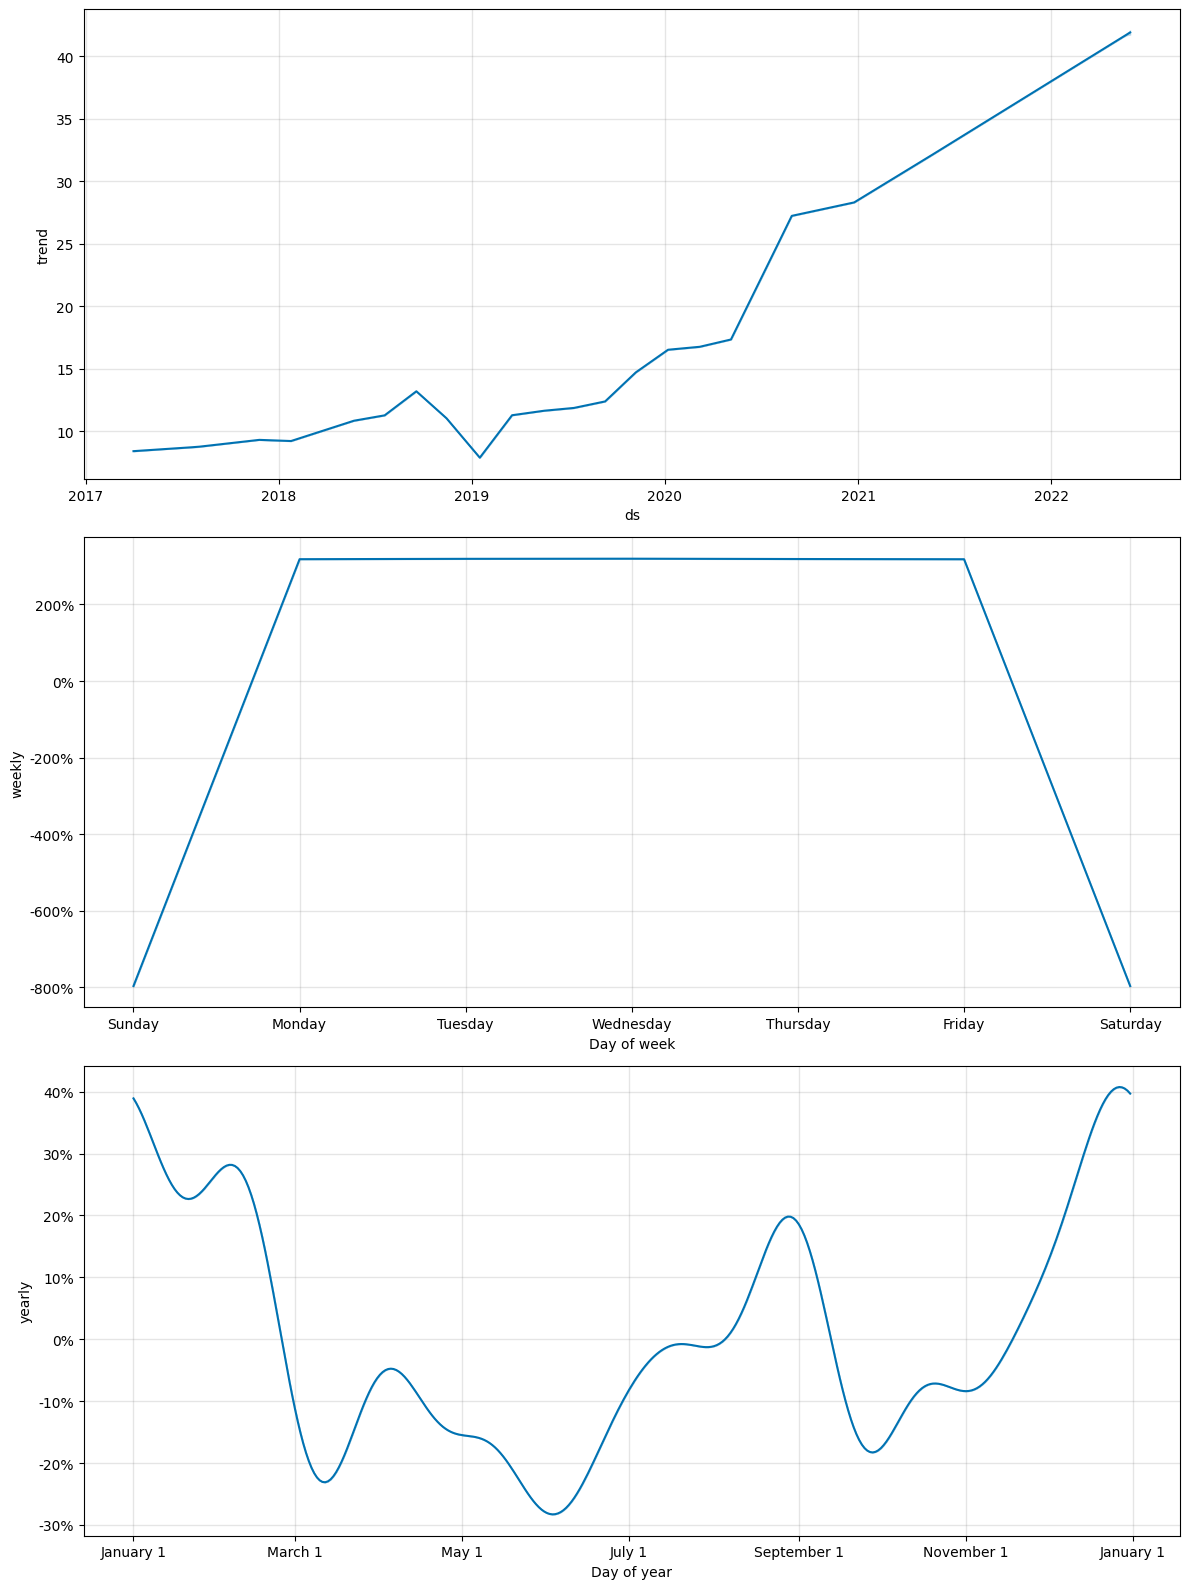

In [514]:
f = m.plot_components(forecast, figsize=(12, 16))

In [515]:
def make_predictions_df(forecast, data_train, data_test): 
    """
    Function to convert the output Prophet dataframe to a datetime index and append the actual target values at the end
    """
    forecast.index = pd.to_datetime(forecast.ds)
    data_train.index = pd.to_datetime(data_train.ds)
    data_test.index = pd.to_datetime(data_test.ds)
    data = pd.concat([data_train, data_test], axis=0)
    forecast.loc[:,'y'] = data.loc[:,'y']
    
    return forecast

def plot_predictions(forecast, start_date):
    """
    Function to plot the predictions 
    """
    f, ax = plt.subplots(figsize=(14, 8))
    
    train = forecast.loc[start_date:'2022-05-01',:]
    ax.plot(train.index, train.y, 'ko', markersize=3)
    ax.plot(train.index, train.yhat, color='steelblue', lw=0.5)
    ax.fill_between(train.index, train.yhat_lower, train.yhat_upper, color='steelblue', alpha=0.3)
    
    test = forecast.loc['2022-05-01':,:]
    ax.plot(test.index, test.y, 'ro', markersize=3)
    ax.plot(test.index, test.yhat, color='coral', lw=0.5)
    ax.fill_between(test.index, test.yhat_lower, test.yhat_upper, color='coral', alpha=0.3)
    ax.axvline(forecast.loc['2022-05-01', 'ds'], color='k', ls='--', alpha=0.7)

    ax.grid(ls=':', lw=0.5)
    
    return f, ax

In [516]:
result = make_predictions_df(forecast, train, test)
result.loc[:,'yhat'] = result.yhat.clip(lower=0)
result.loc[:,'yhat_lower'] = result.yhat_lower.clip(lower=0)
result.loc[:, 'yhat_upper'] = result.yhat_upper.clip(lower=0)
result

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat,y
ds,,,,,,,,,,,,,,,,,,,,
2017-04-01,2017-04-01,8.422931,0.000000,0.000000,8.422931,8.422931,-8.029907,-8.029907,-8.029907,-7.972584,-7.972584,-7.972584,-0.057323,-0.057323,-0.057323,0.0,0.0,0.0,0.000000,NaN
2017-04-02,2017-04-02,8.425832,0.000000,0.000000,8.425832,8.425832,-8.025581,-8.025581,-8.025581,-7.972584,-7.972584,-7.972584,-0.052997,-0.052997,-0.052997,0.0,0.0,0.0,0.000000,NaN
2017-04-03,2017-04-03,8.428732,30.886374,38.911131,8.428732,8.428732,3.134035,3.134035,3.134035,3.183958,3.183958,3.183958,-0.049923,-0.049923,-0.049923,0.0,0.0,0.0,34.844673,33.718447
2017-04-04,2017-04-04,8.431632,31.071894,39.128521,8.431632,8.431632,3.145130,3.145130,3.145130,3.193229,3.193229,3.193229,-0.048099,-0.048099,-0.048099,0.0,0.0,0.0,34.950214,33.969517
2017-04-05,2017-04-05,8.434533,30.764841,39.135821,8.434533,8.434533,3.149179,3.149179,3.149179,3.196678,3.196678,3.196678,-0.047499,-0.047499,-0.047499,0.0,0.0,0.0,34.996383,33.793534
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-26,2022-05-26,41.816825,160.243855,168.982533,41.725478,41.916898,2.934596,2.934596,2.934596,3.188392,3.188392,3.188392,-0.253796,-0.253796,-0.253796,0.0,0.0,0.0,164.532299,143.161047
2022-05-27,2022-05-27,41.842972,159.599614,168.436394,41.733666,41.957850,2.923164,2.923164,2.923164,3.182911,3.182911,3.182911,-0.259746,-0.259746,-0.259746,0.0,0.0,0.0,164.156858,148.995821
2022-05-28,2022-05-28,41.869119,0.000000,0.000000,41.734052,42.001669,-8.237770,-8.237770,-8.237770,-7.972584,-7.972584,-7.972584,-0.265186,-0.265186,-0.265186,0.0,0.0,0.0,0.000000,NaN


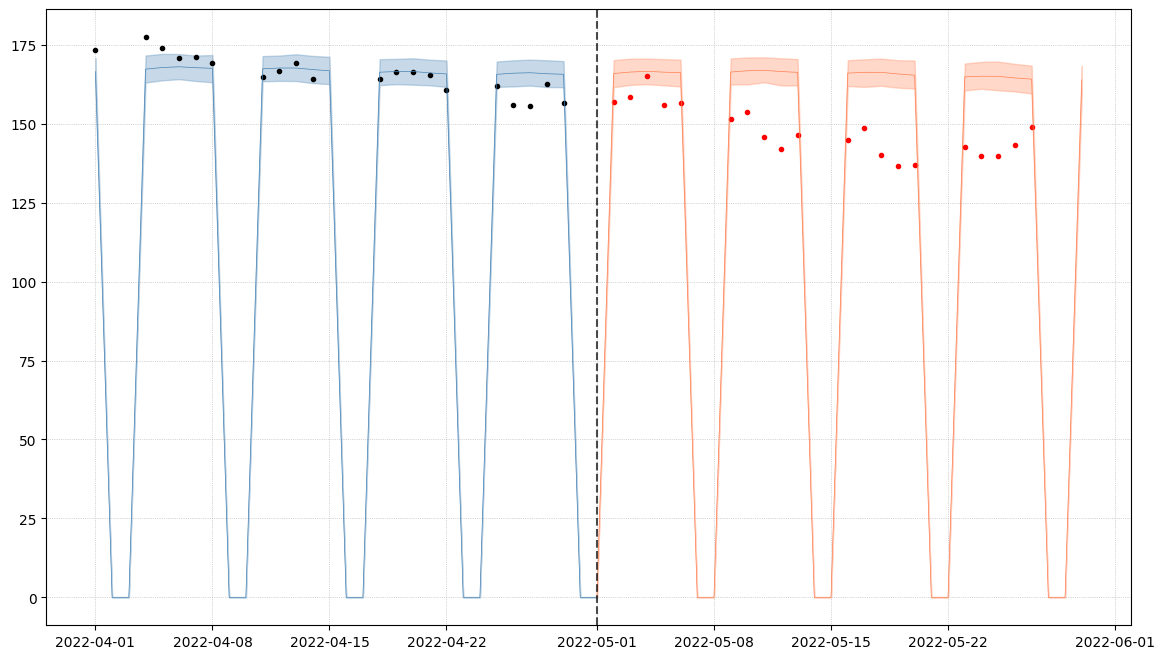

In [518]:
f, ax = plot_predictions(result, '2022-04-01')

In [519]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
result = result.dropna()
mean_squared_error(result.loc['2022-05-01':'2022-05-30','y'],result.loc['2022-05-01':'2022-05-30','yhat'])
result = result.dropna()
mean_absolute_error(result.loc['2022-05-01':'2022-05-30','y'],result.loc['2022-05-01':'2022-05-30','yhat'])

18.179176547367838

# Extra regressors are added

In [563]:
m = Prophet(seasonality_mode='multiplicative',
            yearly_seasonality=True, 
            weekly_seasonality=True,
            daily_seasonality=False)

In [564]:
m.add_regressor('confirmed', mode='multiplicative')
m.add_regressor('GOOG Close', mode='multiplicative')

In [565]:
stock_AAPL_merge

,AAPL Close
2017-04-01,NaN
2017-04-02,NaN
2017-04-03,33.718447
2017-04-04,33.969517
2017-04-05,33.793534
...,...
2022-05-27,148.995821
2022-05-28,NaN
2022-05-29,NaN
2022-05-30,NaN


In [566]:
pd_merged_2=pd.concat([stock_AAPL_merge,stock_GOOG_merge, covid_confirmed_pre],axis=1,join="outer",)
pd_merged_2 = pd_merged_2.reset_index()
pd_merged_2 = pd_merged_2.rename(columns={'index':'ds', 'AAPL Close':'y'})
pd_merged_2 = pd_merged_2.fillna(0)
train_extra, test_extra = train_test_split(pd_merged_2)
train_extra


,ds,y,GOOG Close,confirmed
0,2017-04-01,0.000000,0.0000,0.0
1,2017-04-02,0.000000,0.0000,0.0
2,2017-04-03,33.718447,41.9275,0.0
3,2017-04-04,33.969517,41.7285,0.0
4,2017-04-05,33.793534,41.5705,0.0
...,...,...,...,...
1851,2022-04-26,155.897020,119.5060,80996837.0
1852,2022-04-27,155.668345,115.0205,81081307.0
1853,2022-04-28,162.697630,119.4115,81154876.0
1854,2022-04-29,156.742125,114.9665,81236707.0


In [567]:
m.fit(train_extra)

Initial log joint probability = -171.024


    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5491.25     0.0156777       1682.13           1           1      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       5741.99     0.0119444       3505.09           1           1      252   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       5913.28      0.031241        2464.9           1           1      375   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       5960.34    0.00338993       569.168      0.7376      0.7376      495   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       5975.62    0.00380765        563.56           1           1      615   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     599     

In [573]:
future = m.make_future_dataframe(periods=len(test_extra), freq='1D')
future

,ds
0,2017-04-01
1,2017-04-02
2,2017-04-03
3,2017-04-04
4,2017-04-05
...,...
1882,2022-05-27
1883,2022-05-28
1884,2022-05-29
1885,2022-05-30


In [574]:
# futures = pd.concat([future, stock_GOOG_merge, covid_confirmed_pre].reset_index(drop=True)], axis=1)
futures = pd_merged_2.drop(['y'], axis=1)
futures

,ds,GOOG Close,confirmed
0,2017-04-01,0.0000,0.0
1,2017-04-02,0.0000,0.0
2,2017-04-03,41.9275,0.0
3,2017-04-04,41.7285,0.0
4,2017-04-05,41.5705,0.0
...,...,...,...
1882,2022-05-27,112.7990,83903655.0
1883,2022-05-28,0.0000,83917417.0
1884,2022-05-29,0.0000,83926462.0
1885,2022-05-30,0.0000,83958614.0


In [575]:
forecast = m.predict(futures)

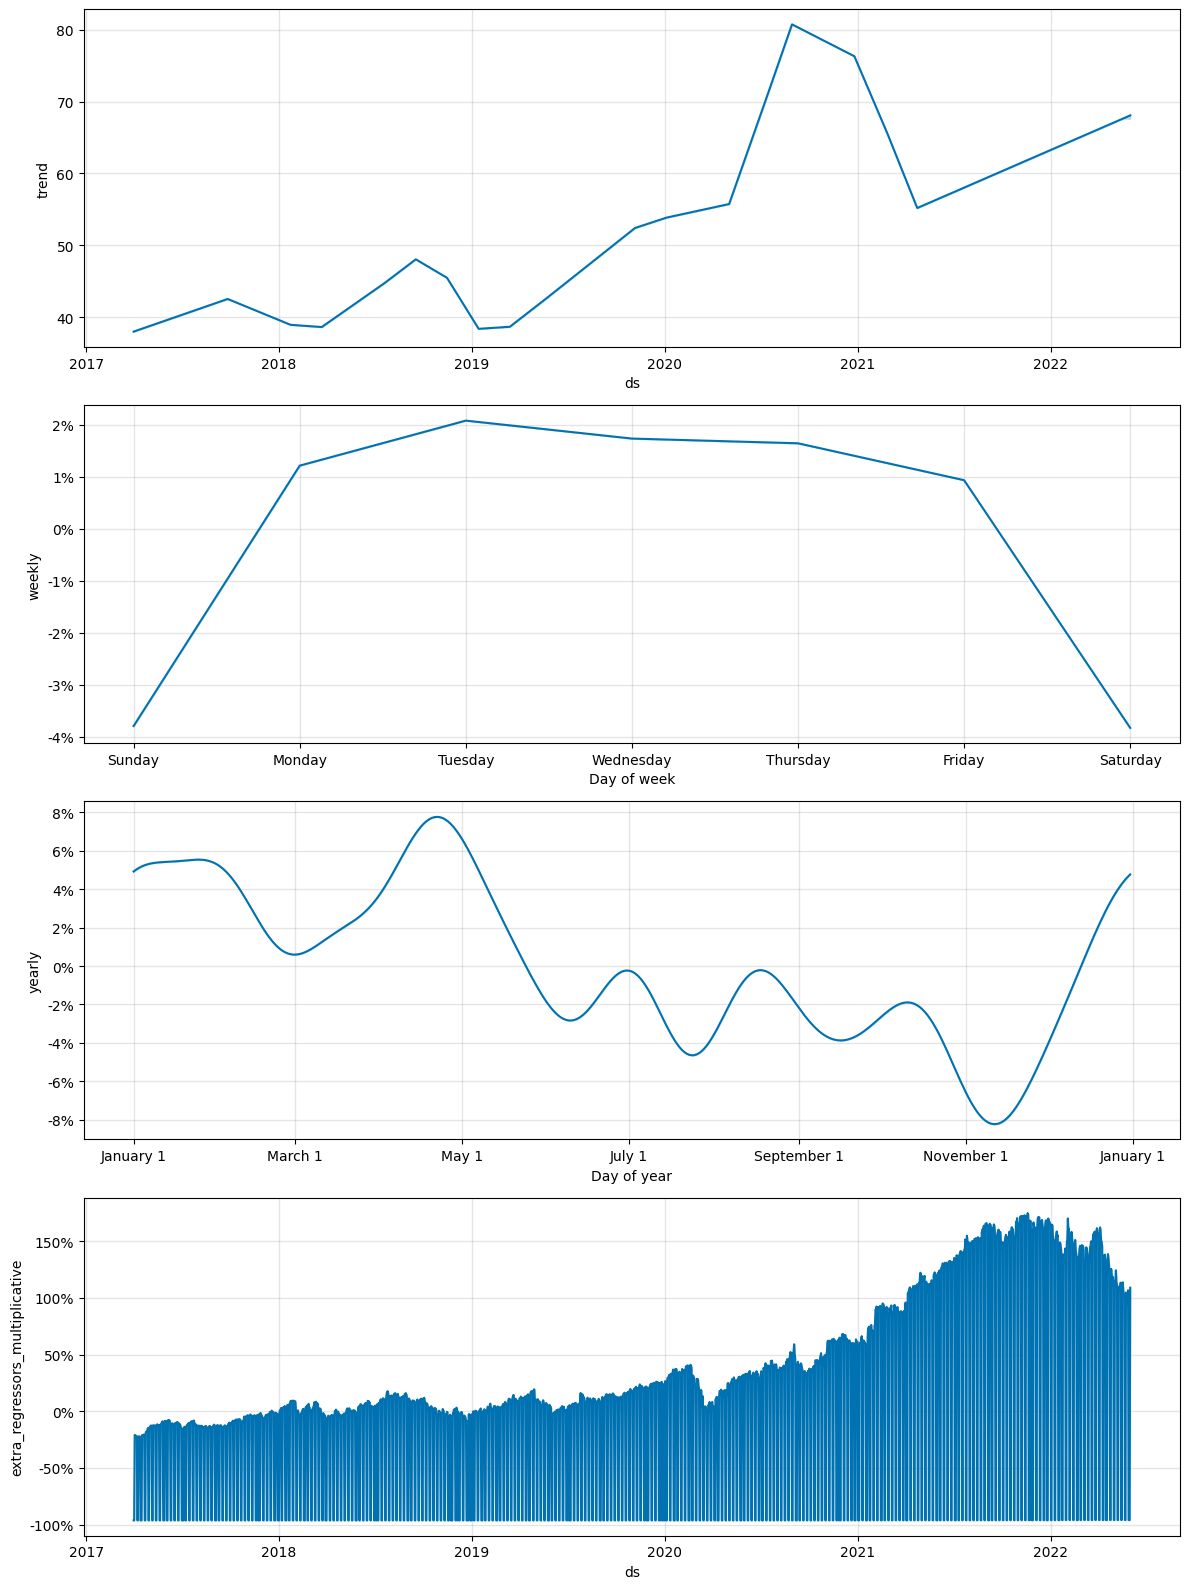

In [576]:
f = m.plot_components(forecast, figsize=(12, 16))

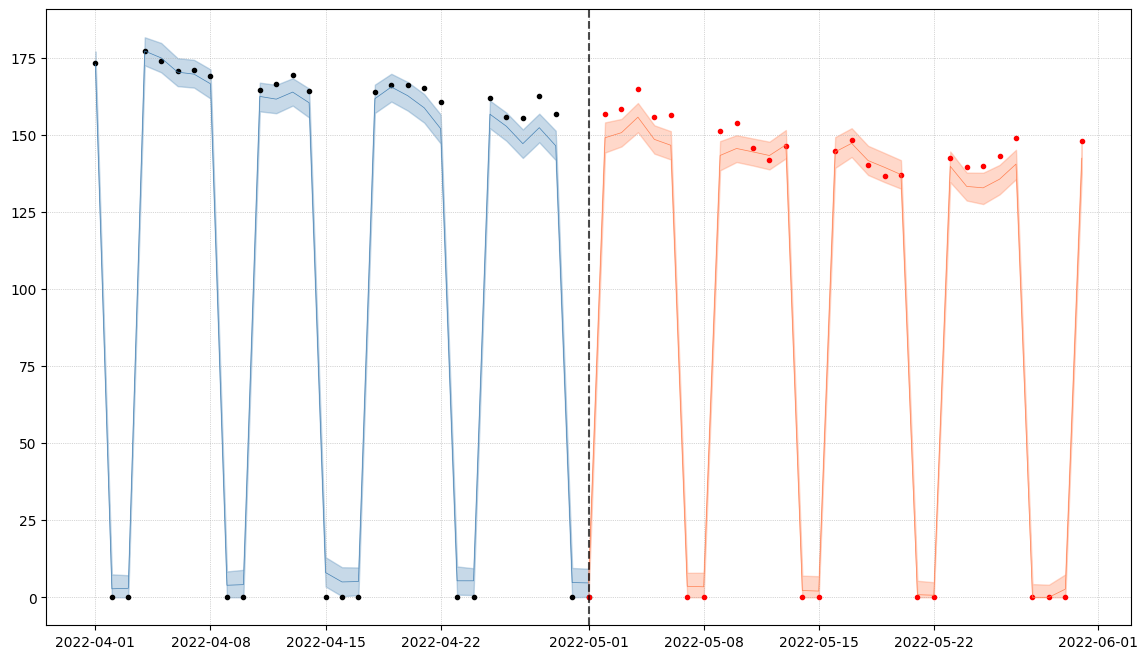

In [577]:
result = make_predictions_df(forecast, train_extra, test_extra)
result.loc[:,'yhat'] = result.yhat.clip(lower=0)
result.loc[:,'yhat_lower'] = result.yhat_lower.clip(lower=0)
result.loc[:, 'yhat_upper'] = result.yhat_upper.clip(lower=0)

f, ax = plot_predictions(result, '2022-04-01')